In [1]:
%matplotlib widget
from typing import Callable, Optional
from dataclasses import dataclass
from functools import partial
import numpy as np
import sympy
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"

import scipy.stats

In [2]:
from montecarlo import MonteCarloEstimate, monte_carlo

# Burgers Equation Case Study
Alex Gorodetsky, January 2024

The viscous [Burgers'](https://en.wikipedia.org/wiki/Burgers'_equation) is a simplified model of the motion of a viscous compressible gas. It has the following parameters

- $x$: spatial variable
- $t$: time variable
- $u(t, x)$: speed of the gas at location $x$ and time $t$
- $\nu$: diffusion coefficient / kinematic viscocity

\begin{equation}
\frac{\partial}{\partial t}u(t, x) = - u(t, x) \frac{\partial}{\partial x} u(t,x) + \nu \frac{\partial^2}{\partial x^2} u(t, x)
\end{equation}

We will also add boundary conditions to this problem $u(t, 0) = u(t, 1) = 0,$ so that the domain of the problem is $x \in [0,1]$

The diffusion coefficient is typically an uncertain positive number. While the viscous burgers has an analytic solution in some cases, it is a prototype for partial differential equations that can only be solved numerically. These can be quite expensive and so Monte Carlo methods are difficult to apply without dimension reduction. 




I have coded up a numerical solution to the Burgers' equation in the imported file `burgers.py` and will use that as the forward model. Here is what the solution looks like.

In [3]:
from burgers import *

Now lets set up some parameters

In [4]:
x = np.linspace(0, 1, 40)
dx = x[1] - x[0]
dt = 1e-4  # must be slow enough for stability
num_steps = 10000
t = np.arange(0, num_steps * dt, dt)
viscosity = 0.1

Finally, lets plot an example solution. The plot in red is an analytic solution, which is known for a special case of boundary conditions and initial conditions. The blue is a numerical solution.

In [5]:
%matplotlib inline
plt.ioff()
fig, ax = plt.subplots()
ax.axis([0, 1, 0, 4])
a, = ax.plot([], [], '-r')
n, = ax.plot([], [], '-b')

ic = get_ic_dirichlet(x, viscosity)
num_sol = solve(dt, dx, num_steps, ic, viscosity)

def animate(ind, t, interval, x, viscosity, num_sol):
    #print("t = ", t)
    u = analytic_solution_dirichlet(t[ind * interval], x, viscosity)
    a.set_data(x, u)
    n.set_data(x, num_sol[ind * interval, :])

plot_every = 100
matplotlib.animation.FuncAnimation(fig,
                                   partial(animate,
                                           t=t,
                                           interval=plot_every,
                                           x=x,
                                           viscosity=viscosity,
                                           num_sol=num_sol),
                                   frames=(num_steps - 1) // plot_every,
                                   repeat=False)


The solution is different for different values of the viscocity. In typical applications the viscosity is a problem attribute that may be uncertain. Here we know it is positive, so we can perhaps imagine that a model for it is some positive random variable. Wikipedia has a nice [list of probability distributions](https://en.wikipedia.org/wiki/List_of_probability_distributions)

Lets use a uniform distribution between 0.1 and 0.9 as an example.

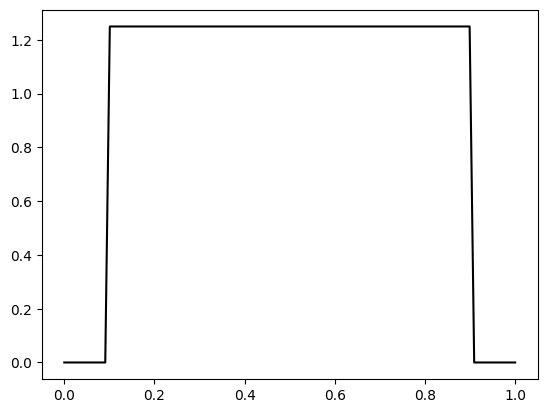

In [6]:
plt.close('all')
nu = np.linspace(0, 1, 100)
nu_rv = scipy.stats.uniform(1e-1, 0.8)

pdf = nu_rv.pdf(nu)
plt.figure()
plt.plot(nu, pdf, '-k')
plt.show()

Using this random variable, lets take a look at the possible realizations of the solution at some different time steps

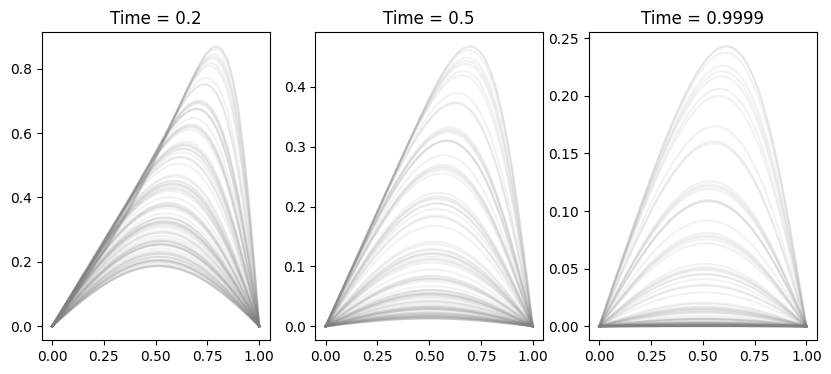

15.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
%%timeit -n 1 -r 1
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
times_plot =  [num_steps // 5, num_steps // 2, num_steps-1]
axs[0].set_title(f"Time = {dt * times_plot[0]}")
axs[1].set_title(f"Time = {dt * times_plot[1]}")
axs[2].set_title(f"Time = {dt * times_plot[2]}")

num_samples = 100
viscosity_samples = nu_rv.rvs(num_samples)
for ii in range(num_samples):
    num_sol = solve(dt, dx, num_steps, ic, viscosity_samples[ii])

    axs[0].plot(x, num_sol[times_plot[0], :], 'gray', alpha=0.1)
    axs[1].plot(x, num_sol[times_plot[1], :], 'gray', alpha=0.1)
    axs[2].plot(x, num_sol[times_plot[2], :], 'gray', alpha=0.1)

plt.show()

So now that we have realizations of the solution, we may ask a question. Such as -- at the last time step, what is the expected speed at $x=0.75$, what is the variance at $x=0.75$, or a million other things. All of which can be represented as expected values, and addressed with monte carlo. For example, for the expected value at 0.75 we would use.

E[u(t_final, 0.75)] is approximately 0.030123791110213283


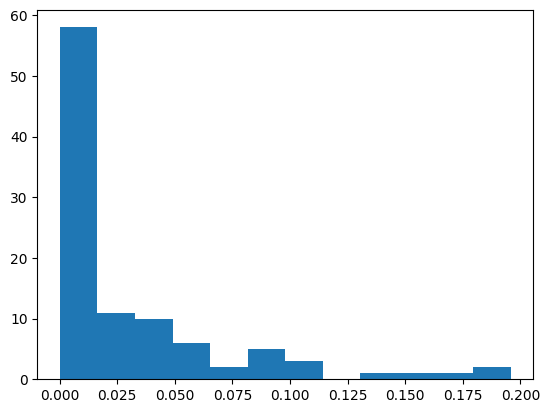

In [8]:
ind_075 =  np.argmax(x>=0.75)
def g(param):
    out = np.zeros(param.shape[0])
    for ii in range(param.shape[0]):
        sol = solve(dt, dx, num_steps, ic, param[ii])
        out[ii] = sol[-1, ind_075]
        if np.isnan(out[ii]):
            print(f"{param[ii]} leads to NAN")
            print(sol[-1, :])
    return out

mc = monte_carlo(100, nu_rv.rvs, g)
print(f"E[u(t_final, 0.75)] is approximately", mc.estimate)
plt.figure()
plt.hist(mc.evaluations, bins='auto')
plt.show()